IA & Data science (LU3IN0226) -- 2021-2022
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Olivier Schwander.*


(version 2 du sujet, remplace celui publié sur le Moodle le lundi 7 février)

#  Semaine 3 : algorithme du perceptron de Rosenblatt

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

In [1]:
# GOJAK Zlatan, LABADY Sterley Gilbert 

*Double-cliquer ici et insérer les noms 

1.   GOJAK Zlatan
2.   LABADY Sterley Gilbert

et prénoms de votre binôme*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-03</tt> et rajouter à la suite de <tt>tme-03</tt> les noms des membres du binômes séparés par un tiret.

In [2]:
# Pour connaître la version de python utilisée:
import sys
print("Version Python: ",sys.version)

# une version >= 3.7 est recommandée

Version Python:  3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-03-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

Les imports suivants seront généralement nécessaires:

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

# Les instructions suivantes sont TRES utile pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

## Retour sur le sujet du TME 2

In [4]:
# ------------------------ REPRENDRE ICI LES FONCTIONS SUIVANTES DU TME 2:
# genere_dataset_uniform:
def genere_dataset_uniform(n, p, inf, sup):
    np.random.seed(42)  
    data_desc = np.random.uniform(inf,sup,(p,n)) 
    data_label = np.asarray([-1 for i in range(0,int(p/2))] + [+1 for i in range(0,int(p/2))])
    return data_desc, data_label

# genere_dataset_gaussian:
def genere_dataset_gaussian(pc, ps, nc, ns, nbp):
    pos = np.random.multivariate_normal(pc, ps, size=nbp)
    neg = np.random.multivariate_normal(nc, ns, size=nbp)
    tab1 = np.vstack((pos, neg))
    tab2 = np.asarray([-1 for i in range(nbp)] + [+1 for i in range(nbp)])
    return tab1, tab2
# plot2DSet:
def plot2DSet(array1, array2):
    # Extraction des exemples de classe -1:
    data2_negatifs2 = array1[array2 == -1]
    # Extraction des exemples de classe +1:
    data2_positifs2 = array1[array2 == +1]
    plt.scatter(data2_negatifs2[:,0],data2_negatifs2[:,1],marker='o', color="red") # 'o' rouge pour la classe -1
    plt.scatter(data2_positifs2[:,0],data2_positifs2[:,1],marker='x', color="blue") # 'x' bleu pour la classe +1

# plot_frontiere:
def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    # colors[0] est la couleur des -1 et colors[1] est la couleur des +1
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])


Taille du dataset généré : (200, 2) exemples
Les 5 premiers exemples :
<class 'numpy.ndarray'> 
 [[1.49671415 0.8617357 ]
 [1.64768854 2.52302986]
 [0.76584663 0.76586304]
 [2.57921282 1.76743473]
 [0.53052561 1.54256004]]


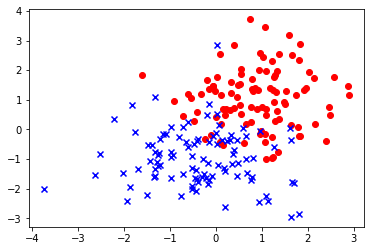

In [5]:
# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

# On génère un dataset de 200 exemples en dimension 2:
data_gauss_desc, data_gauss_label = genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-0.5,-1]),np.array([[1,0],[0,1]]),100)

print("Taille du dataset généré :", np.shape(data_gauss_desc), "exemples")

print("Les 5 premiers exemples :")
print(type(data_gauss_desc), '\n', data_gauss_desc[0:5,:])

# Affichage des exemples générés:
plot2DSet(data_gauss_desc, data_gauss_label)

*italicised text*## Perceptron de Rosenblatt

De la même façon que nous avons défini des classes pour le classifieur par k-ppv et le classifieur linéaire aléatoire, nous allons maintenant définir une nouvelle classe de classifieurs pour implémenter l'algorithme présenté dans le cours 3 : le perceptron de Rosenblatt.

*Il est fortement conseillé d'étudier les transparents du cours 3 avant de s'attaquer à l'implémentation de cet algorithme.*


<div class="alert alert-block alert-info">

**Apprentissage:**<BR>
L'apprentissage d'un perceptron consiste à partir d'une base de données étiquetées $X \in \mathbb R^{n\times d},Y\in \{-1,1\}^n$ de fournir un vecteur de paramètres optimisés $\mathbf w\in \mathbb R^{d}$.

En termes algorithmiques, l'apprentissage est itératif:
1. Initialisation de $\mathbf w$ soit à 0, soit aléatoirement. Attention, si l'initialisation est aléatoire, **les valeurs doivent être très petites** et également réparties entre valeurs positives et négatives pour ne pas biaiser l'algorithme. On pourra dans ce cas pour générer chaque composante de $w$: 1) générer aléatoirement une valeur $v$ dans $[0,1[$, 2) la transformer en $2v-1$ pour qu'elle soit dans $[-1,1[$, puis 3) la multiplier par un nombre réel positif petit (par exemple $0.001$) pour obtenir une valeur très petite.
1. Optimisation stochastique grâce à $X$:
    1. Choisir aléatoirement un exemple $\mathbf x_i$
    1. Evaluer l'erreur de prédiction pour $\mathbf x_i, y_i$ avec le vecteur $\mathbf w$ courant
        1. Si *Pas d'erreur*, pas de correction
        1. Si *Erreur*, corriger $\mathbf w$ : 
        $$\mathbf w \leftarrow \mathbf w + \epsilon y_i \mathbf x_i$$
        Le *learning rate* $\epsilon \in [0,1]$ est défini à la création du classifieur.
    1. Arrêter lorsqu'il y a convergence:
        1. Convergence = aucun ou peu de changements sur $\mathbf w$ pendant $n$ itérations. Pour évaluer le changement, on calcule la norme de la valeur absolue de la différence terme à terme entre $w$ (vecteur avant l'étape 2) et $w'$ (vecteur après l'étape 2). Il y a convergence quand cette valeur descend en dessous d'un seuil de convergence (qui est un réel positif non nul).
        1. Remarque : on peut fixer un nombre d'itérations maximum au bout desquelles l'algorithme s'arrêtera pour ne pas se coincer dans une boucle infinie.

**Classification / Prédiction / Inférence :**<BR>
L'inférence est linéaire: 
    $$\hat y_i =  \mathbf x_i \cdot \mathbf w , \qquad \hat y_i^* =\text{sign}(\hat y_i) \in \{-1,1\}$$
   
   $\hat y_i$ correspond au score fourni par le perceptron (valeur réelle donc) et $y_i^*$ correspond à la prédiction (+1 ou -1).
    
Attention à ne pas confondre l'évaluation linéaire à valeur réelle et le signe qui permet de mettre notre estimation dans le même univers que les étiquettes d'origine.
    
    
</div>    

<font color="RED" size="+1">**[Q]**</font> En héritant de la classe `Classifier` (qu'il faut donc récupérer/ré-écrire pour la mettre dans ce notebook), écrire la classe `ClassifierPerceptron` qui implémente l'algorithme du perceptron de Rosenblatt vu en cours. 

Lors de l'initialisation, dans la méthode `__init__`, le learning_rate (aussi noté <i>epsilon</i>) pour le perceptron doit être fourni. On utilise aussi un argument de nom `init` qui vaut 0 (par défaut) ou 1 et qui donne le mode souhaité d'initialisation du perceptron: soit en mettant les poids $w_1, \ldots, w_d$ à 0, soit en les initialisant aléatoirement par des valeurs très petites comme expliqué dans le descriptif ci-dessus.

La fonction `train_step` d'un perceptron doit réaliser **une itération complète** du dataset d'apprentissage $X$ en prenant les exemples dans un ordre aléatoire. Cet ordre est tiré au moment de l'exécution de la fonction `train`. Pour chaque exemple d'apprentissage $x$, on détermine le score donné par le perceptron et avec ce score on corrige les valeurs des poids du perceptron. Cette correction dépend de $x$ et de l'écart entre le score et la vraie classe de $x$, elle est pondérée par le learning rate du perceptron. 

La fonction `train` d'un perceptron doit implémenter l'algorithme complet de l'apprentissage itératif du perceptron à partir du dataset d'apprentissage $X$. Cette fonction prend en argument, en plus du dataset, un entier `niter_max` qui donne le nombre d'itérations maximal à réaliser, et un réel `seuil` qui donne le seuil de convergence à atteindre. cette fonction rend la liste des valeurs des différences rencontrées.

Remarque: quelques fonctions utiles :
- la fonction `np.zeros` qui prend en argument un entier. Par exemple, tester `np.zeros(10)`.
- la fonction `np.random.shuffle` qui prend une liste de valeurs en arguments et la modifie (par effet de bord) en réordonnant aléatoirement les valeurs.
- pour copier un `np.array`, il est nécessaire d'utiliser la méthode `copy()` qui réalise une copie profonde. Par exemple, `B = A.copy()` pour copier le `np.array A` dans la variable `B`.

In [6]:
# Par exemple :

np.random.seed(42)   # on prend 42 comme graine

l =[i for i in range(0,10)]
print("Avant: ",l)
np.random.shuffle(l)
print("Après: ",l)

Avant:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Après:  [8, 1, 5, 0, 7, 2, 9, 4, 3, 6]


In [7]:
# ------------------------ A COMPLETER :

from numpy.core.fromnumeric import size
# ------------------------ A COMPLETER :
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        raise NotImplementedError("Please Implement this method")
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        # ------------------------------
        # COMPLETER CETTE FONCTION ICI : 
        
        count=0
        for i in range(len(label_set)):
          if self.predict(desc_set[i]) == label_set[i]:
            count+=1
        return count/len(label_set)
        
        # ------------------------------



In [39]:
# ------------------------ A COMPLETER : DEFINITION DU CLASSIFIEUR PERCEPTRON
import random
from math import sqrt
from random import randint

class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate, init=0):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate : epsilon
                - init est le mode d'initialisation de w: 
                    - si 0 (par défaut): initialisation à 0 de w,
                    - si 1 : initialisation par tirage aléatoire de valeurs petites
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.init = init
        res = []
        if init == 0:
          self.w_de_base = np.asarray(np.zeros(self.input_dimension))
        elif init == 1:
          for i in range(self.input_dimension):
            res.append((2*i - 1)*0.001)
          self.w_de_base = np.asarray(res)
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """    
        
        liste_indice = np.random.permutation(len(desc_set))
        for i in liste_indice:
            x=desc_set[i]
            y=label_set[i]
            pred = self.predict(x)
            if y != pred:
                self.w_de_base = self.w_de_base + self.learning_rate*x*y
                
        return self.w_de_base
     
    def train(self, desc_set, label_set, niter_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - niter_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """     

        ret = []  
        i = 1
        w_old = self.train_step(desc_set, label_set)
        while i < niter_max:
          w_new = self.train_step(desc_set, label_set)
          d = np.linalg.norm(w_old - w_new)
          ret.append(d)
          #if i != 1:
            #if d < seuil:
              #break
          w_old = w_new.copy()
          i += 1
        ret.pop(0)
        return ret
    
    def score(self,x):
        score = 0
        for i in range(len(x)):
            score += self.w_de_base[i] * x[i]
        return score
    def predict(self, x):
        score = self.score(x)
        return 1 if score >= 0.0 else -1

    

## Validation de l'algorithme

<font color="RED" size="+1">**[Q]**</font>  Afin de vérifier le bon fonctionnement de l'algorithme, nous allons procéder à une série de test:

1. Test sur les gaussiennes jouets définies précédemment
    1. Vérifier l'impact du réglage de l'initialisation (normalement, il n'y a pas trop d'impact sur un problème aussi simple)
    1. Vérifier l'impact du réglage de epsilon (impact énorme: ca diverge très rapidement!!)
    1. En jouant sur la génération des données, tester votre perceptron dans le cas facile (nuages des deux classes bien séparés) puis dans le cas plus difficile où les classes ne sont plus séparables linéairement.

1. Test sur les données USPS (cf. TME 2)
    1. Nous travaillerons uniquement dans le cas binaire. Prendre les 1 vs 2 (cas facile) puis les 3 vs 6 ou 9 (cas nettement plus dur)
    
1. Penser à faire le parallèle avec le temps d'inférence sur les k-ppv de la semaine précédente
    
**Note:** il faut évidemment multiplier les boites et ne pas tout faire au même endroit.

### Test sur des gaussiennes jouets

#### Apprentissage pas à pas et variation d'accuracy

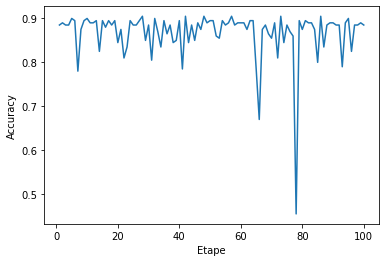

Accuracy finale :  0.885


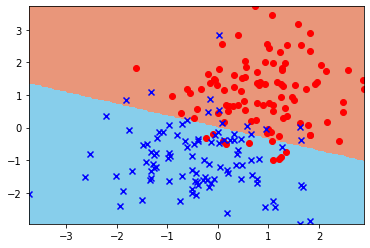

In [40]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine pour tester

# -----
# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron1 = ClassifierPerceptron(2, learning_rate, 0)

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_gauss_desc
label_train = data_gauss_label

# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Liste qui va servir à mémoriser les accuracy du perceptron à chaque étape:
val_acc = []
# Réalisation de N itérations 

N = 100
for i in range(N):
  perceptron1.train_step(data_train, label_train)
  val_acc.append(perceptron1.accuracy(data_train, label_train))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1, len(val_acc)+1),val_acc)
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()

# -----
# Affichage de la frontière de séparation des classes
plot_frontiere(data_train,label_train,perceptron1,step=150)
plot2DSet(data_train,label_train)

print("Accuracy finale : ", perceptron1.accuracy(data_train,label_train))

### Apprentissage et affichage de la convergence

Nb iterations réalisées:  100


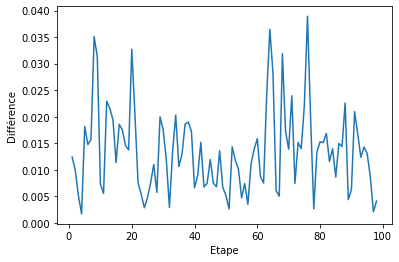

Accuracy finale :  0.885


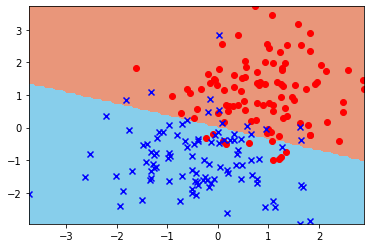

In [10]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron2 = ClassifierPerceptron(2, learning_rate, 0)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_gauss_desc
label_train = data_gauss_label

# Apprentissage du perceptron jusqu'à convergence
les_variations = perceptron2.train(data_train, label_train, niter_max=100)
print("Nb iterations réalisées: ",100)

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Affichage de la frontière de séparation des classes
plot_frontiere(data_train,label_train,perceptron2,step=100)
plot2DSet(data_train,label_train)

print("Accuracy finale : ", perceptron2.accuracy(data_train,label_train))

### Initialisation aléatoire et convergence

Nb iterations réalisées:  100


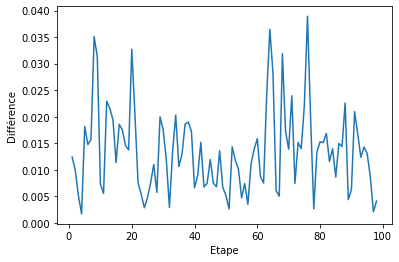

Accuracy finale :  0.885


In [11]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation aléatoire et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron3 = ClassifierPerceptron(2, learning_rate, 0)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_gauss_desc
label_train = data_gauss_label

# Apprentissage du perceptron
les_variations = perceptron3.train(data_train, label_train)
print("Nb iterations réalisées: ",100)

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

print("Accuracy finale : ", perceptron2.accuracy(data_train,label_train))

### Impact du learning rate

<font color="RED" size="+1">[Q]</font> Tester différentes valeurs de learning rate et regarder les résultats en termes de convergence.

Par exemple, que se passe-t-il quand le learning rate est mis à 0.1?

Nb iterations réalisées:  1000


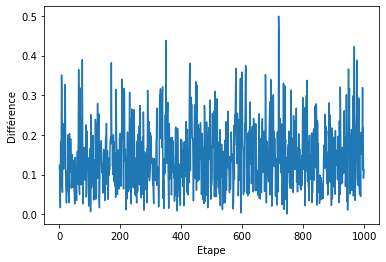

Accuracy finale :  0.89


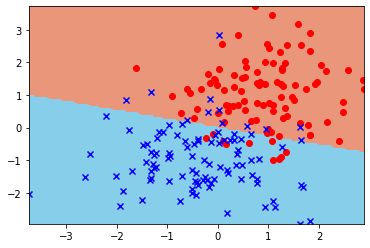

In [12]:
# Par exemple : 

# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_gauss_desc
label_train = data_gauss_label

# Création d'un perceptron avec initialisation aléatoire et le learning_rate ci-dessous:
learning_rate = 0.1
perceptron4 = ClassifierPerceptron(2, learning_rate, 0)

# Apprentissage du perceptron
les_variations = perceptron4.train(data_train, label_train, niter_max=1000)
print("Nb iterations réalisées: ",1000)

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Affichage de la frontière de séparation des classes
plot_frontiere(data_train,label_train,perceptron4,step=100)
plot2DSet(data_train,label_train)

print("Accuracy finale : ", perceptron4.accuracy(data_train,label_train))

<font color="RED" size="+1">[Q]</font> Quand le learning rate est mis à 0.01, en utilisant le paramètre `niter_max`, trouver combien d'itérations sont nécessaires pour que l'algorithme converge.

In [13]:
np.random.seed(42)   # on prend 42 comme graine


### Evaluation sur un dataset de test

In [14]:
# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

nb_exemples_test = 500
d_desc_test, d_lab_test = genere_dataset_gaussian(np.array([1,1]), \
                                                    np.array([[1,0],[0,1]]),\
                                                    np.array([-0.5,-1]),\
                                                    np.array([[1,0],[0,1]]),\
                                                    nb_exemples_test)

print("Taille du test généré :", np.shape(d_desc_test), "exemples")




Taille du test généré : (1000, 2) exemples


Nb iterations:  98


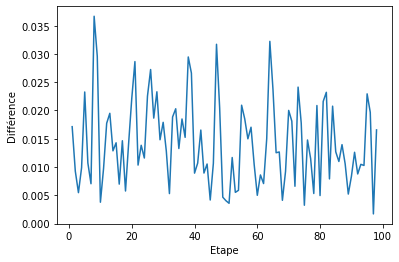

Accuracy finale sur train :  0.89
Accuracy finale sur test :  0.872


In [15]:
# ------------------------ COMPLETER LES INSTRUCTIONS DANS CETTE BOITE 

np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron
perceptron_eval = ClassifierPerceptron(2,0.01,init=1)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train, label_train = data_gauss_desc, data_gauss_label

# Apprentissage du perceptron
les_variations = perceptron_eval.train(data_train, label_train)
print("Nb iterations: ",len(les_variations))

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Définition des données de test
data_test, label_test = d_desc_test, d_lab_test

print("Accuracy finale sur train : ", perceptron_eval.accuracy(data_train,label_train))
print("Accuracy finale sur test : ", perceptron_eval.accuracy(data_test,label_test))

## Sur-apprentissage

Comme expliqué en cours, le sur-apprentissage consiste à apprendre une règle:
1. parfaite sur les données d'apprentissage
1. mais absurde ou inutile sur les données *en général*

Votre but de data-scientist est d'éviter ce piège. Il existe de nombreuses stratégies pour faire face à ce défi majeur... Mais la première chose à faire est de savoir détecter le problème.

<img src="ressources/overfitting.png" > <BR>
<center>FIG: la proposition de droite est parfaite sur les données observées en apprentissage... Mais absurde en général
</center>

<font color="RED" size="+1">**[Q]**</font>   Pour ce faire, nous allons toujours évaluer nos algorithmes sur des données *neutres*, c'est à dire sur des données n'ayant pas servi à l'apprentissage.

1. Dans le cas de données jouets générées: tirer un second jeu de données avec les mêmes paramètres
1. Dans le cas USPS (toujours en 2 classes), récupérer les données de test et évaluer votre modèle dessus

Comparer les performances en apprentissage (c'est-à dire sur le dataset qui a servi à construire entraîner le modèle) et en test (c'est-à-dire sur un dataset différent du dataset d'apprentissage).


## Cas difficiles

<font color="RED" size="+1">[Q]</font> Afin de tester des cas plus difficiles (c'est-à-dire non séparables linéairement), écrire la fonction `createXOR` qui permet de générer le jeu de données ci-dessous. Cette fonction prend 2 arguments, un nombre de points $n$ et un réel positif $\sigma$ donnant la variance sur chaque dimension et permet de jouer sur la dispersion des nuages et donc sur la séparation des 4 nuages.

Il s'agit de générer des points dans deux classes mais selon 4 gaussiennes.

<img src="ressources/xor.png" width=300px>



In [16]:
def create_XOR(n, sigma):
  one = sigma * np.random.randn(n, 2) + [0, 0]
  two = sigma * np.random.randn(n, 2) + [1, 1]
  three = sigma * np.random.randn(n, 2) + [0, 1]
  four = sigma * np.random.randn(n, 2) + [1, 0]
  return (np.vstack((one, two, three, four)), np.hstack((-1*np.ones(2*n), np.ones(2*n))))

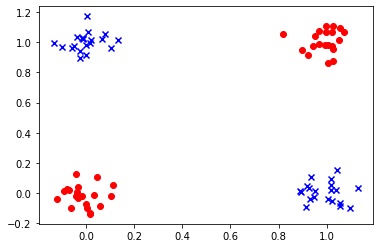

In [17]:
# une fois le fichier d'outils mis à jour, vous devez pouvoir faire:

np.random.seed(42)   # on prend 42 comme graine

# Génération d'un dataset avec 80 points:
data_xor, label_xor = create_XOR(20,0.07)
plot2DSet(data_xor, label_xor)


<font color="RED" size="+1">[Q]</font> Appliquer l'algorithme du perceptron sur ces données et constater (avec quelques affichages de performances et tracés de frontières de décision) que ça ne marche pas!

Nb iterations réalisées:  100


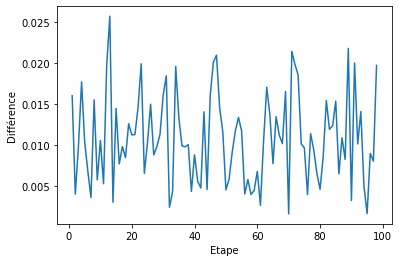

Accuracy finale :  0.6125


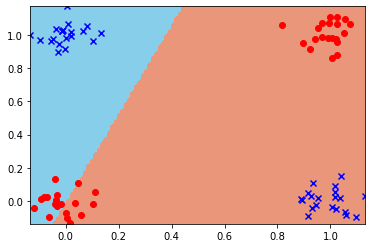

In [18]:
np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
perceptron2 = ClassifierPerceptron(2, 0.01, 0)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_xor
label_train = label_xor

# Apprentissage du perceptron jusqu'à convergence
les_variations = perceptron2.train(data_train, label_train, niter_max=100)
print("Nb iterations réalisées: ",100)

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Affichage de la frontière de séparation des classes
plot_frontiere(data_train,label_train,perceptron2,step=100)
plot2DSet(data_train,label_train)

print("Accuracy finale : ", perceptron2.accuracy(data_train,label_train))

Kernel Trick
--------------

Les résultats précédents ne sont vraiment pas très bons, le perceptron n'arrive pas à séparer correctement les 2 classes... (expliquer pourquoi)

<div class="alert alert-block alert-info">

L'**astuce du noyau ("kernel trick")** est un moyen pour améliorer ses performances.

Un **noyau** est une **fonction** (on parle de *fonction noyau*, *noyau* ou *kernel*) qui permet de représenter des données d'un espace donné dans un autre espace, souvent de dimension plus grande.

Comme vu en cours, l'idée est toute simple.

Par exemple, on considère une matrice en 2D d'observations:
$$X =\left[
    \begin{array}{cc}
    x_{11} & x_{12}\\
    \vdots & \vdots \\
    x_{N1} & x_{N2}\\
    \end{array}
    \right]\in \mathbb R^{N\times 2}$$

La fonction produite par un perceptron, $f(\mathbf x) = \mathbf w \cdot \mathbf x$, correspond à une frontière linéaire dans l'espace 2D... Qui passe par $(0,0)$.

Mais supposons que nous ajoutons des colonnes à $X$:
$$X^* =\left[
    \begin{array}{cccccc}
    x_{11} & x_{12} & x_{11}^2 & x_{12}^2 & x_{11} x_{12} & 1 \\
    \vdots & \ddots &&&&\vdots\\
    x_{N1} & x{N2} & x_{N1}^2 & x_{N2}^2 & x_{N1} x_{N2} & 1 \\
    \end{array}
    \right]\in \mathbb R^{N\times 6}$$

Les colonnes ajoutées sont obtenues à partir des colonnes initiales de $X$.

Maintenant, la fonction $f(\mathbf x^*) = \mathbf w \cdot \mathbf x^*$ correspond toujours à une frontière linéaire mais cette fois-ci dans un espace 6D... 
Mais sa projection dans l'espace 2D d'origine est une frontière non linéaire !


Un **noyau**  est donc une fonction de transformation
$$\begin{array}{cccc}
    K:& X & \rightarrow & X^*\\
      & \mathbf x & \mapsto &\mathbf x^*
\end{array}$$

</div>

**Note** Il faudra être très attentif, on fait tous les calculs avec des $\mathbf x^*$ mais on fait tous les affichages avec des $\mathbf x$...

Pour représenter des noyaux, on définit une classe abstraite `Kernel` qui sera étendue pour chaque noyau que l'on souhaitera créer.

In [19]:
# CLasse (abstraite) pour représenter des noyaux
class Kernel():
    """ Classe pour représenter des fonctions noyau
    """
    def __init__(self, dim_in, dim_out):
        """ Constructeur de Kernel
            Argument:
                - dim_in : dimension de l'espace de départ (entrée du noyau)
                - dim_out: dimension de l'espace de d'arrivée (sortie du noyau)
        """
        self.input_dim = dim_in
        self.output_dim = dim_out
        
    def get_input_dim(self):
        """ rend la dimension de l'espace de départ
        """
        return self.input_dim

    def get_output_dim(self):
        """ rend la dimension de l'espace d'arrivée
        """
        return self.output_dim
    
    def transform(self, V):
        """ ndarray -> ndarray
            fonction pour transformer V dans le nouvel espace de représentation
        """        
        raise NotImplementedError("Please Implement this method")


L'intérêt de définir une telle classe `Kernel` pour définir des noyaux est qu'elle permettra de définir des algorithmes de façon générique qui pourront alors prendre des noyaux quelconques en argument.

### Un premier noyau

Le premier noyau, très simple, que l'on définit permet de projeter (manuellement) des données 2D dans un espace de plus grande dimension. 

Voici un exemple de projection qui transforme le vecteur $(x_1,x_2)$ en vecteur $(x_1,x_2,1)$

In [20]:
class KernelBias(Kernel):
    """ Classe pour un noyau simple 2D -> 3D
    """
    def transform(self, V):
        """ ndarray de dim 2 -> ndarray de dim 3            
            rajoute une 3e dimension au vecteur donné
        """
        V_proj = np.append(V,np.ones((len(V),1)),axis=1)
        return V_proj

In [21]:
# Exemple d'utilisation : 
kb = KernelBias(2,3)

data_xor_bias= kb.transform(data_xor)

print("data_xor:\n", data_xor[0:5,:])

print("\ndata_xor_transf:\n", data_xor_bias[0:5,:])

data_xor:
 [[ 0.03476999 -0.0096785 ]
 [ 0.0453382   0.10661209]
 [-0.01639074 -0.01638959]
 [ 0.1105449   0.05372043]
 [-0.03286321  0.0379792 ]]

data_xor_transf:
 [[ 0.03476999 -0.0096785   1.        ]
 [ 0.0453382   0.10661209  1.        ]
 [-0.01639074 -0.01638959  1.        ]
 [ 0.1105449   0.05372043  1.        ]
 [-0.03286321  0.0379792   1.        ]]


### Un noyau un peu plus compliqué

<font color="RED" size="+1">**[Q]**</font> Définir la classe `KernelPoly` permettant de représenter le noyau : $(x_1,x_2) \mapsto (1,x_1,x_2,x_1*x_1,x_2*x_2,x_1*x_2)$. 

In [22]:
# ------------------------ A COMPLETER :

class KernelPoly(Kernel):
    def transform(self,V):
        """ ndarray de dim 2 -> ndarray de dim 6            
            ...
        """
        ##TODO
        ret = []
        for x in V:
          temp = []
          temp.append(float(1.0))
          temp.append(float(x[0]))
          temp.append(float(x[1]))
          temp.append(float(x[0]**2))
          temp.append(float(x[1]**2))
          temp.append(float(x[0]*x[1]))
          ret.append(temp)

        return np.asarray(ret)


In [23]:
# Exemple d'utilisation 

kp = KernelPoly(2,6)

data_xor_poly = kp.transform(data_xor)

<font color="RED" size="+1">**[Q]**</font> Implémenter la classe `ClassifierPerceptronKernel` qui étend la classe `Classifier`. 
Pour définir cette classe possède les mêmes fonctionnalités que celles de la classe `ClassifierPerceptron`, en plus, elle prend en argument, lors de sa construction, un noyau (instance de la classe `Kernel`).
Une différence majeure avec le perceptron normal, et que le dataset fourni pour les méthodes `train_step` et `train`, ainsi que l'exemple donnée pour une prédiction, doit être *kernélisé* avant d'appliquer le traitement.

*Remarques :*
- le données sont donc kernélisée dans l'objet `ClassifierPerceptronKernel`.
- **attention**: **Python n'est pas un vrai langage objet** et ne permet pas d'utiliser pleinement l'héritage comme le permet Java, on ne peut donc pas faire hériter `ClassifierPerceptronKernel` de `ClassifierPerceptron` pour pouvoir réutiliser certaines méthodes, on est forcé de réécrire les méthodes `train_step`,  `train`, `score` et `predict`.
 


In [24]:
# ------------------------ A COMPLETER : DEFINITION DU CLASSIFIEUR PERCEPTRON
import random
from math import sqrt
from random import randint

class ClassifierPerceptronKernel(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate, noyau, init=0):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate : epsilon
                - init est le mode d'initialisation de w: 
                    - si 0 (par défaut): initialisation à 0 de w,
                    - si 1 : initialisation par tirage aléatoire de valeurs petites
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.init = init
        res = []
        if init == 0:
          self.w_de_base = np.asarray(np.zeros(self.input_dimension))
        elif init == 1:
          for i in range(self.input_dimension):
            res.append((2*i - 1)*0.001)
          self.w_de_base = np.asarray(res)
        self.noyau = noyau
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """ 
        desc_set = self.noyau.transform(desc_set)
        liste_indice = np.random.permutation(len(desc_set))
        for i in liste_indice:
            x=desc_set[i]
            y=label_set[i]
            pred = self.predict(x)
            if y != pred:
                temp = self.w_de_base + self.learning_rate*x*y
                self.w_de_base = temp

        return self.w_de_base
     
    def train(self, desc_set, label_set, niter_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - niter_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """     

        ret = []  
        i = 1
        w_old = self.train_step(desc_set, label_set)
        while i < niter_max:
          w_new = self.train_step(desc_set, label_set)
          d = np.linalg.norm(w_old - w_new)
          ret.append(d)
          #if i != 1:
            #if d < seuil:
              #break
          w_old = w_new.copy()
          i += 1
        ret.pop(0)
        return ret
    
    def score(self,x):
      if len(x) < 6:
          temp = []
          temp.append(float(1.0))
          temp.append(float(x[0]))
          temp.append(float(x[1]))
          temp.append(float(x[0]**2))
          temp.append(float(x[1]**2))
          temp.append(float(x[0]*x[1]))
          x = temp
      score = 0
      for i in range(len(x)):
        score += self.w_de_base[i] * x[i]
      return score
    
    def predict(self, x):
      score = self.score(x)
      return 1 if score >= 0.0 else -1

    

<font color="RED" size="+1">**[Q]**</font> Entraîner un perceptron kernelisé utilisant un `KernelPoly` sur un dataset correspondant au XOR. Que constate-t-on ? Expliquer.

Nb iterations réalisées:  100


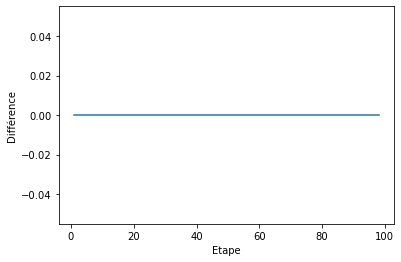

Accuracy finale :  1.0


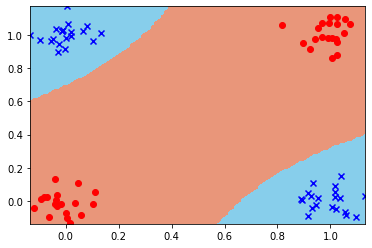

In [25]:
np.random.seed(42)   # on prend 42 comme graine

# Création d'un perceptron avec initialisation à 0 et le learning_rate ci-dessous:
learning_rate = 0.01
kp = KernelPoly(2,6)
perceptron2 = ClassifierPerceptronKernel(6, 0.01, kp, 0)

# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
data_train = data_xor
label_train = label_xor

# Apprentissage du perceptron jusqu'à convergence
les_variations = perceptron2.train(data_train, label_train, niter_max=100)
print("Nb iterations réalisées: ",100)

# Traçage de la courbe des variations
plt.plot(range(1,len(les_variations)+1),les_variations)  
plt.ylabel('Différence')
plt.xlabel("Etape")
plt.show()

# Affichage de la frontière de séparation des classes
plot_frontiere(data_train,label_train,perceptron2,step=100)
plot2DSet(data_train,label_train)

acc = kp.transform(data_train)
print("Accuracy finale : ", perceptron2.accuracy(acc,label_train))

## Expérimentations

Compléter ce notebook par des expérimentations sur le Perceptron, par exemple :
1. Test sur les données USPS (cf. TME 2)
    1. Nous travaillerons uniquement dans le cas binaire. Prendre les 1 vs 2 (cas facile) puis les 3 vs 6 ou 9 (cas nettement plus dur)
    
1. Faire le parallèle avec le temps d'inférence sur les k-ppv de la semaine précédente
